# BarcodeBabel draft 6

Rules:
1. User-defined enzyme cleavage sites
    * Defaults: `GRA` on both ends
    * Specify separately for beginning and end
    * Enzyme function needs to be edited to match user cleavage site
2. User-defined frequencies of amino acids:
    * Defaults: Frequencies will be 0 for some: K, R, H, C, M, P
3. User-defined m/z range at user-defined pH
    * Defaults: pH = 3, m/z range: 550-850
4. User-defined maximum length of allowed repeats
    * Default: 2
5. User-defined hydrophobicity range:
    * Default: Updated with proteometools hydrophobicity range - max hydrophobic windows
6. User-defined library size:
    * Default: 2000
7. Disallow overlap with reference proteome
    
Properties 3 and 5 must be satisfied by the trypsinized barcode (e.g. instead of computing `property("GRAxxxGRA")` we want to compute `property("AxxxGR")`)

In [1]:
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from Bio import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint, positive_pKs, negative_pKs
import matplotlib.pyplot as plt
%matplotlib inline

# Construct sampling distributions over amino acids
standard_amino_acids = sorted(list('AGILPVFWYDERHKSTCMNQ'))
index_of_aa = dict(zip(standard_amino_acids, range(len(standard_amino_acids))))

# uniform distribution
uniform_distribution = np.ones(len(standard_amino_acids)) / len(standard_amino_acids)

def sample_random_peptide(length=10, residue_frequencies=uniform_distribution):
    """Sample a random peptide of specified length, with specified AA probabilities"""
    return ''.join(np.random.choice(standard_amino_acids, size=length, p=residue_frequencies))

In [2]:
# proportions for starting random peptide
flycode_dict = {
    'A': 0.1,
    'S': 0.1,
    'T': 0.1,
    'N': 0.00,
    'Q': 0.00,
    'D': 0.1,
    'E': 0.1,
    'V': 0.1,
    'L': 0.1,
    'F': 0.1,
    'Y': 0.00,
    'W': 0.1,
    'G': 0.1,
    'P': 0.00,
}

flycode_distribution = np.zeros(len(standard_amino_acids))
for aa in flycode_dict:
    flycode_distribution[index_of_aa[aa]] = flycode_dict[aa]
assert(np.sum(flycode_distribution) == 1)

In [3]:
residues_to_avoid = ['K', 'R', 'H', 'M', 'C', 'P', 'Q','N','I']
def avoid_certain_residues(initial_distribution, residues_to_avoid):
    """Take an initial distribution, and set the probability for each element of residues_to_avoid to 0, then renormalize"""
    censored_distribution = np.array(initial_distribution)
    for aa in residues_to_avoid:
        censored_distribution[index_of_aa[aa]] = 0
    assert(np.sum(censored_distribution) > 0)
    return censored_distribution / np.sum(censored_distribution)
residue_frequencies = avoid_certain_residues(flycode_distribution, residues_to_avoid)
print('initial sampling distribution: ')
for i in range(len(standard_amino_acids)):
    print('\t{}: {:.3}%'.format(standard_amino_acids[i], residue_frequencies[i]*100))

initial sampling distribution: 
	A: 10.0%
	C: 0.0%
	D: 10.0%
	E: 10.0%
	F: 10.0%
	G: 10.0%
	H: 0.0%
	I: 0.0%
	K: 0.0%
	L: 10.0%
	M: 0.0%
	N: 0.0%
	P: 0.0%
	Q: 0.0%
	R: 0.0%
	S: 10.0%
	T: 10.0%
	V: 10.0%
	W: 10.0%
	Y: 0.0%


In [4]:
def compute_mz(peptide, pH=1):
    """Return the mass over charge ratio for a peptide at a specified pH"""
    from pyteomics.mass import calculate_mass
    from pyteomics.electrochem import charge
    return calculate_mass(peptide) / charge(sequence=peptide, pH=pH)

def check_longest_repetition(peptide):
    """Return the length of the longest string of repeated characters in the peptide"""
    prev_aa = peptide[0]
    longest_repetition = 1
    current_repetition = 1
    for i in range(1, len(peptide)):
        if peptide[i] == prev_aa:
            current_repetition += 1
        else:
            prev_aa = peptide[i]
            longest_repetition = max(current_repetition, longest_repetition)
            current_repetition = 1
    return longest_repetition

kyte_doolittle_scale = { 'A': 1.8,'R':-4.5,'N':-3.5,'D':-3.5,'C': 2.5,
       'Q':-3.5,'E':-3.5,'G':-0.4,'H':-3.2,'I': 4.5,
       'L': 3.8,'K':-3.9,'M': 1.9,'F': 2.8,'P':-1.6,
       'S':-0.8,'T':-0.7,'W':-0.9,'Y':-1.3,'V': 4.2 }

def compute_hydrophobicity_profile(peptide, window=5):
    """Return the hydrophobicity profile along the peptide using the Kyte-Doolittle scale"""
    analysis = ProteinAnalysis(peptide)
    window = min(window, len(analysis.sequence))
    hydrophobicity_profile = analysis.protein_scale(kyte_doolittle_scale, window=window)
    return hydrophobicity_profile

def acceptable_hydrophobicity_profile(peptide, min_hydrophobicity=-2, max_hydrophobicity=2):
    """Return True if the MAXIMUM along the hydrophobicity profile is >= min_hydrophobicity,
    and the MAXIMUM along the hydrophobicity_profile is <= max_hydrophobicity"""
    hydrophobicity_profile = compute_hydrophobicity_profile(peptide)
    return (np.max(hydrophobicity_profile) >= min_hydrophobicity) and (np.max(hydrophobicity_profile) <= max_hydrophobicity)

def no_long_repetitions(peptide, max_n_repeat=2):
    """Return True only if the sequence contains no strings of repeated characters
    longer than threshold."""
    return check_longest_repetition(peptide) <= max_n_repeat

def mz_in_range(peptide, min_mz=550, max_mz=850, pH=1):
    """Return True only if m/z ratio is within desired interval"""
    mz = compute_mz(peptide, pH=pH)
    return (mz >= min_mz) and (mz <= max_mz)

def avoids_certain_residues(peptide, residues_to_avoid):
    """Return True only if the peptide contains none of the residues_to_avoid"""
    return len(set(peptide).intersection(set(residues_to_avoid))) == 0

In [5]:
class ReferenceProteome():
    def __init__(self,
                 path_to_fasta):
        """Basic, will speed this up if needed"""
        self.load_from_fasta_file(path_to_fasta)
        self.path_to_fasta = path_to_fasta
    
    def load_from_fasta_file(self, path_to_fasta):
        self.reference_sequences = []
        for seq_record in SeqIO.parse(path_to_fasta, "fasta"):
            self.reference_sequences.append(str(seq_record.seq))
    
    def check_if_in_reference_proteome(self, peptide):
        for reference_seq in self.reference_sequences:
            if peptide in reference_seq:
                return True
        return False

reference_proteome = ReferenceProteome(path_to_fasta='20181017_UPR_homo_cRAP_tatfly.fasta')

In [6]:
peptide = "GRALEDTGDSDEGRA"
peptide.split("GRA")

['', 'LEDTGDSDE', '']

In [8]:
compute_mz(peptide,1)

524.9110126343559

In [7]:
%%timeit
_ = sum([peptide in seq for seq in reference_proteome.reference_sequences])

17.8 ms ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit
_ = reference_proteome.check_if_in_reference_proteome(peptide)

16.3 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
def append_enzyme_cleavage_sites(peptide, initial='GRA', end='GRA'):
    """Add fixed sequences to the beginning and end of the barcode"""
    return ''.join([initial, peptide, end])

def trypsinize(peptide):
    """GRAxxxGRA --> AxxxGR"""
    split = peptide.split("GRA")
    assert(len(split) == 3)
    return ''.join(['A', split[1], 'GR'])

def sample_random_length(min_length=3, max_length=25):
    """Pick a random integer given inclusive bounds"""
    return np.random.randint(min_length, max_length+1)

def sample_from_trial_distribution():
    """Sample a random length, then sample a random peptide of that length"""
    return append_enzyme_cleavage_sites(sample_random_peptide(sample_random_length(), residue_frequencies))

def not_in_reference_proteome(peptide):
    """Return True only if this peptide sequence is not present in the reference proteome"""
    return not reference_proteome.check_if_in_reference_proteome(peptide)

max_n_repeat = 2
min_mz = 500
max_mz = 800
pH = 1.0
min_hydrophobicity = -0.5
max_hydrophobicity = 2.5

constraints = [
    lambda peptide : no_long_repetitions(peptide, max_n_repeat=max_n_repeat),
    lambda peptide : mz_in_range(trypsinize(peptide), min_mz=min_mz, max_mz=max_mz, pH=pH),
    lambda peptide : acceptable_hydrophobicity_profile(trypsinize(peptide), min_hydrophobicity=min_hydrophobicity, max_hydrophobicity=max_hydrophobicity),
    lambda peptide : not_in_reference_proteome(trypsinize(peptide)),
]

def satisfies_all_constraints(peptide):
    """Return True only if each function in the constraints list returns True"""
    for constraint in constraints:
        if not constraint(peptide):
            return False
    return True

from tqdm import tqdm
def generate_library(library_size, sample_from_trial_distribution, check_constraints, max_n_trials=int(1e9)):
    """Build a library by sampling peptides from the trial distribution, and adding them to the library
    if they satisfy all the constraints, and if they're not already in the library."""
    library = []
    trange = tqdm(range(1, max_n_trials + 1))
    for i in trange:
        trial = sample_from_trial_distribution()
        if trial not in library:
            if check_constraints(trial):
                library.append(trial)
        trange.set_postfix({'current library size': len(library),
                            'current yield percentage': 100.0 * len(library) / i
                           })
        if len(library) >= library_size:
            print('target library size achieved! terminating early')
            break
    if len(library) < library_size:
        print('target library size not achieved, returning the library assembled so far')
    return library

In [13]:
# what fraction of trial peptides satisfy all our constraints?
np.mean([satisfies_all_constraints(sample_from_trial_distribution()) for _ in range(10000)])

0.1813

In [ ]:
np.random.seed(0)
trial_peptides = [sample_from_trial_distribution() for _ in range(10000)]
lengths = list(map(len, trial_peptides))

In [ ]:
trial_peptides[0]

In [ ]:
mz_for_random_peptides = np.array(list(map(lambda p: compute_mz(trypsinize(p)), trial_peptides)))

In [ ]:
hist_heights = plt.hist(mz_for_random_peptides, bins=50, alpha=0.5)[0];
plt.ylabel('probability density')
plt.yticks([])
plt.xlabel('m/z')
plt.title('m/z for random trial peptides')

#plt.vlines([min_mz, max_mz], 0, max(hist_heights)*1.1)
plt.fill_between([min_mz, max_mz], [0]*2, [max(hist_heights)*1.1]*2, color='green', alpha=0.3)
#plt.fill_between([min(mz_for_random_peptides), min_mz], [0]*2, [max(hist_heights)]*2, color='grey', alpha=0.3)
#plt.fill_between([max_mz, max(mz_for_random_peptides)], [0]*2, [max(hist_heights)]*2, color='grey', alpha=0.3)

In [ ]:
plt.scatter(lengths, mz_for_random_peptides, s=1)
plt.title('m/z vs. length for random trial peptides')
plt.xlabel('length')
plt.ylabel('m/z')
#plt.hlines([min_mz, max_mz], min(lengths), max(lengths))
plt.fill_between([min(lengths), max(lengths)], [max_mz]*2, [min_mz]*2, color='green', alpha=0.3)

In [14]:
# generate library of random peptides that satisfy all the constraints
np.random.seed(0)
library = generate_library(library_size=100,
                          sample_from_trial_distribution=sample_from_trial_distribution,
                          check_constraints=satisfies_all_constraints)

  0%| | 524/1000000000 [00:02<1649:11:28, 168.43it/s, current library size=100, current yield percentage=18.3]

target library size achieved! terminating early


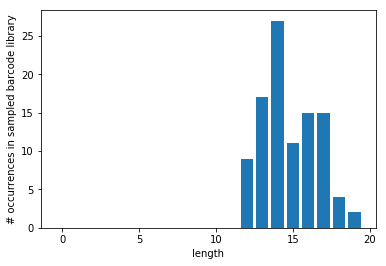

In [15]:
lengths = list(map(len, library))
plt.bar(np.arange(max(lengths)+1), np.bincount(lengths))
plt.xlabel('length')
plt.ylabel('# occurrences in sampled barcode library')
plt.xticks(np.arange(max(lengths) + 2)[::5])

plt.savefig('sample-librar-length.png', dpi=300)

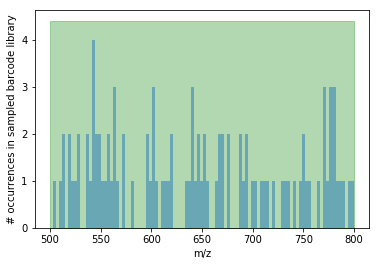

In [16]:
mz_for_library_peptides = np.array(list(map(lambda p: compute_mz(trypsinize(p)), library)))
hist_heights = plt.hist(mz_for_library_peptides, bins=100, alpha=0.5)[0];
plt.xlabel('m/z')
plt.ylabel('# occurrences in sampled barcode library')
plt.fill_between([min_mz, max_mz], [0]*2, [max(hist_heights)*1.1]*2, color='green', alpha=0.3)

plt.savefig('sample-librar-m-z.png', dpi=300)

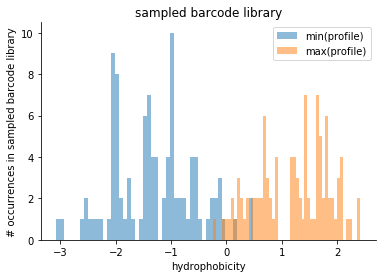

In [17]:
hydrophobicity_profiles = list (map(compute_hydrophobicity_profile,library))
min_hydrophobicities = list (map(np.min,hydrophobicity_profiles))
max_hydrophobicities = list (map(np.max,hydrophobicity_profiles))

ax = plt.subplot(111)
plt.hist(min_hydrophobicities, bins = 50, alpha = 0.5, label = 'min(profile)');
plt.hist(max_hydrophobicities, bins = 50, alpha = 0.5, label = 'max(profile)');
plt.xlabel('hydrophobicity')
plt.ylabel('# occurrences in sampled barcode library')
plt.legend(loc='best')
plt.title('sampled barcode library')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('sample-librar-hydrophobicity.png',dpi=300)

In [18]:
def describe_peptide(peptide):
    barcode = peptide
    tryptic = trypsinize(peptide)
    mz_of_tryptic_digest = compute_mz(trypsinize(peptide))
    maxhyd = np.max(compute_hydrophobicity_profile(trypsinize(peptide)))
    return ','.join([barcode,tryptic, str(mz_of_tryptic_digest), str(maxhyd)])

lines = list(map(describe_peptide, sorted(library)))

In [19]:
with open('barcode-library-550-560-descriptors.csv', 'w') as f:
    f.writelines(['barcode,tryptic digest, m/z of tryptic digest,maximum hydrophobocity tryptic digest, TAT-barcode-HIS-fwd,TAT-barcode-HIS-rev\n'])
    f.writelines(['{}\n'.format(line) for line in lines])